In [1]:
#Here to
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'
# docker start sparkbook
import pyspark as ps

spark = (ps.sql.SparkSession.builder 
        .master("local[6]") # Use 6 of 8 Cores
        .appName("case study") 
        .getOrCreate()
        )
sc = spark.sparkContext

In [2]:
df_json = spark.read.json('../data/french_tweets.json')

# create a temporary table for spark.sql queries
df_json.createOrReplaceTempView('temp_view')

In [ ]:
#filter results ofquery with content_filter
#do counts for filtered results by hour/variable of choice
#create df, transpose created df
#apply counts to df
#graph df


In [3]:
def ho_testing(x):
    '''
    Inputs: x= list of lists   
    output: a p_value 
    '''
    return stats.ttest_ind(x[0],x[1],alternative= "two-sided",equal_var =False)

Lets explore the text among possible senesitve tweets with media where the language is English

In [ ]:
q3 = spark.sql('''
SELECT lang , text,created_at, possibly_sensitive, quoted_status.favorite_count, entities.media.type
FROM temp_view
WHERE lang = 'en' and possibly_sensitive = "True";
''').collect()

In [ ]:
def content_filter(q):
    '''
    Inputs = list results from sql
    Operations = clean text
    Returns = dict 
    '''
    content_df={}
    for item in q:

        time = item[2] 
        time2 = item[2][10:16]
        status = str(item[3])
        n_likes=str(item[4])
        photo_check = str(item[5])
        
        if n_likes != 'None':
            n_likes = int( ''.join(n_likes.strip(':') )) 
        if status != 'True' and status != 'False':
            status = int(status)
            
        vals = [time,status,n_likes,photo_check]
        
        content_df[time2] = vals    
        
    return content_df      

In [ ]:
#collecting data for ho testing on media type and flagged yes 
dfcon= content_filter(q3[0:78600 & 79500:])

media_type_counts = {'photo_likes':0}
photo_likes = 'photo_likes'
acum=0
for k,v in dfcon.items():
    media_type = v[3]
    likes = str(v[2])
    
    if likes == 'None':
        likes = 0
    acum+=int(likes)
    if media_type not in media_type_counts:
        
        media_type_counts[media_type]=1
        media_type_counts['photo_likes'] += int(likes)
        
    else:
        media_type_counts[media_type]+=1
          
print(media_type_counts,likes)
    
#go Through and collect / count occurances 
#of the 205 Flagged posts with media, 48 had a photo attachment and 133 did not
#For the 50 likes from the 205 flagged posts with media 23 had likes, giving an average like 0.2

In [4]:
# possibly sensitive results for all quoted_status
q1 = spark.sql(
'''
SELECT created_at, possibly_sensitive
FROM temp_view; 
'''
).collect()

#tally tweets by hour. 

def times_hour(q):
    by_hour2={}
    for item in q:
        time = item[0][10:13]
        status = str(item[1])
        
        #text = item[2]
        if time not in by_hour2:
            by_hour2[time]={'yes':0, 'no':0, 'nao':0}
        if len(status) < 0:
            status = 'nao'
        if time in by_hour2.keys():
            if status == 'True':
                by_hour2[time]['yes'] +=1
            if status == 'False':
                by_hour2[time]['no']+=1
            else:
                by_hour2[time]['nao']+=1
    return by_hour2       

In [5]:
by_hour = times_hour(q1[0:78600 & 79500:])
print(type(by_hour))

<class 'dict'>


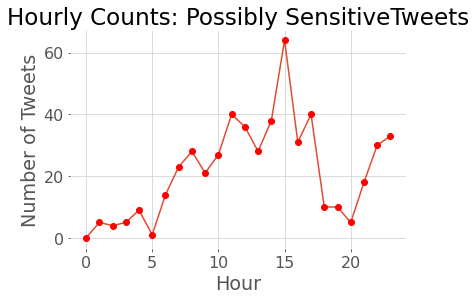

<Figure size 576x720 with 0 Axes>

In [6]:
#print n_sensitive tweets per hour
lst=[]
for k,v in by_hour.items():
    k_=int(k)
    c=list(v.values())
    lst.append((k_,c[0]))
lst.sort(key = lambda x: x[0])

x_val = [i[0] for i in lst]
y_val = [i[1] for i in lst]
plt.title('Hourly Counts: Possibly SensitiveTweets')
plt.xlabel('Hour')
plt.ylabel('Number of Tweets')
plt.plot(x_val,y_val)
plt.plot(x_val,y_val, 'or')
plt.figure(figsize=(8,10))
plt.savefig('Hourly_Counts.png')
plt.show()

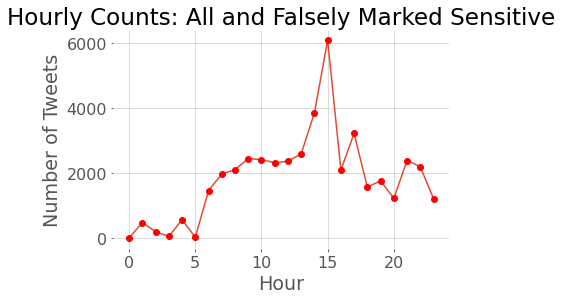

<Figure size 576x720 with 0 Axes>

In [8]:
#as Compared to all tweets per hour 
lst_all=[]
for k,v in by_hour.items():
    k_=int(k)
    c=list(v.values())
    lst_all.append((k_,c[2]))
lst_all.sort(key = lambda x: x[0])

x_val = [i[0] for i in lst_all]
y_val_all = [i[1] for i in lst_all]
plt.title('Hourly Counts: All and Falsely Marked Sensitive')
plt.xlabel('Hour')
plt.ylabel('Number of Tweets')
plt.plot(x_val,y_val_all)
plt.plot(x_val,y_val_all, 'or')
plt.figure(figsize=(8,10))
plt.savefig('HourlyFALSE_Counts.png')
plt.show()

In [57]:
# spark.sql(
# '''
# SELECT quoted_status.possibly_sensitive, temp_view.entities.media.type,
#        COUNT(quoted_status.retweet_count) AS ReTweeet_count, 
#        AVG(quoted_status.retweet_count) AS avg_re_count,
#        stddev_samp(quoted_status.favorite_count) AS std_re_count,
#        max(quoted_status.favorite_count) AS max_re_count,
#        MIN(quoted_status.favorite_count) AS min_re_count
# FROM temp_view
# GROUP BY quoted_status.possibly_sensitive AND temp_view.entities.media.type; 
# '''
# ).show()

In [31]:
def processing1(queryz):
    '''
    input: Spark SQL query as list of rows
    work: remove NoneType, None Values, count values
    return: results from hypothesis test
    '''
    qq_ = [(item[0],str(item[1])) for item in queryz] # dealing with NoneType 
    sq1 = [int(item[0]) for item in qq_ if item[1] != 'None']
    sq2 = [int(item[0]) for item in qq_ if item[1] == 'None']

    if len(sq1) < 3 or len(sq2) < 3:
        return f'Insufficient Data to test: sizes are {len(sq1)} , {len(sq2)}'  
    combo = [sq1,sq2]
    perform_test = ho_testing(combo)
    return perform_test

In [42]:
def processing2(queryz2):
    '''
    input: Spark SQL query as list of rows
    work: remove NoneType, None Values, count values
    return: results from hypothesis test
    '''
    #among the possibly_senesitive tweets marked as False, those with media will not have sig different average like rates
    qq_1 = [(str(item[0]),str(item[1])) for item in queryz2 if str(item[1]) != 'None']
    qq_2 = [(str(item[0]),str(item[1])) for item in queryz2 if str(item[1]) == 'None'] # dealing with NoneType 

    sq1 = [int(item[0]) for item in qq_1 if item[0] != 'None'] 
    sq2 = [int(item[0]) for item in qq_2 if item[0] != 'None']

    if len(sq1) < 3 or len(sq2) < 3:
        return f'Insufficient Data to test: sizes are {len(sq1)} , {len(sq2)}'  

    combo = [sq1,sq2]
    perform_test = ho_testing(combo)
    return perform_test

# Hypothesis Testing

In [17]:
#This is the first hypothesis being tested
qq = spark.sql(
'''
SELECT quoted_status.retweet_count, temp_view.entities.media.type
FROM temp_view
WHERE quoted_status.possibly_sensitive= True;
'''
).collect() 

In [35]:
print(processing1(qq))

Insufficient Data to test: sizes are 0 , 512


'''
Given there are no possibly sensitive tweets marked as True with media , there is insufficient evidence to reject the Ho.
'''

We can now scale our test upwords to see if, at any level, there is evidence that would support the alternative.

Among Possibly sensitive tweets marked False 
Ho : retweet counts will Not be significantly different.
Ha : retweet counts will be significantly different.

In [37]:
#This is the second hypothesis being tested
q_false = spark.sql(
'''
SELECT quoted_status.retweet_count, temp_view.entities.media.type
FROM temp_view
WHERE quoted_status.possibly_sensitive= False;
'''
).collect() 

print(processing1(q_false))
# Ttest_indResult(statistic=0.7119210156567528, pvalue=0.25414453508235946)

Ttest_indResult(statistic=0.7119210156567528, pvalue=0.5082890701647189)


We still fail to reject the Ho

What about at the next largest scale? Among ALL quoted satus.
' ' 
Ho: Among retweets those with media will Not have significantly different average retweet counts
Ha: Among retweets those with media will have significantly different average retweet counts

In [49]:
#This is third

retweet_all = spark.sql('''
SELECT quoted_status.retweet_count, temp_view.entities.media.type 
FROM temp_view ;
''').collect()
 
print(processing2(retweet_all))
#Ttest_indResult(statistic=0.8624315870353153, pvalue=0.4215514201308371)

Ttest_indResult(statistic=0.8624315870353153, pvalue=0.4215514201308371)


We continue fail to reject the Ho. There Does not seem to be evidence to support the hypothesis that media influences retweet status. 

-Does the trend of media not impacting tweet popularity continue when we switch our dependent variable to like_count ? 

In [45]:
# possibly sensitive results for all quoted_status
# spark.sql(
# '''
# SELECT quoted_status.possibly_sensitive, entities.media.type,
#        COUNT(quoted_status.favorite_count) AS fav_count, 
#        AVG(quoted_status.favorite_count) AS avg_n_count,
#        stddev_samp(quoted_status.favorite_count) AS std_n_likes,
#        max(quoted_status.favorite_count) AS max_n_likes,
#        MIN(quoted_status.favorite_count) AS min_n_likes
# FROM temp_view
# GROUP BY quoted_status.possibly_sensitive AND entities.media.type; 
# '''
# ).show()

In [47]:
san_likes = spark.sql('''
SELECT possibly_sensitive, quoted_status.favorite_count, temp_view.entities.media.type 
FROM temp_view
WHERE possibly_sensitive=True;
''').collect()
san1 = pd.DataFrame(san_likes)
san1.rename(columns = {0:'Sensitive', 1:'Like Count', 2:'Media' }, inplace=True)

In [52]:
print(processing1(san_likes))

Ttest_indResult(statistic=nan, pvalue=nan)


'''
Given there are no possibly sensitive tweets marked as True with media , there is insufficient evidence to reject the Ho.
'''

We can now scale our test upwords to see if, at any level, there is evidence that would support the alternative hypotheses and/or allow us to reject the Ho.

Among Possibly sensitive tweets marked False 
Ho : Favorite counts will Not be significantly different among those with media 
Ha : Favorite counts will be significantly different among those with media 

In [53]:
san_false_likes = spark.sql('''
SELECT possibly_sensitive, quoted_status.favorite_count, temp_view.entities.media.type 
FROM temp_view
WHERE possibly_sensitive=False ;
''').collect()

In [55]:
#among the possibly_senesitive tweets marked as False, those with media will not have sig different average like rates
qq_1 = [(str(item[1]),str(item[2])) for item in san_false_likes if str(item[2]) != 'None']
qq_2 = [(str(item[1]),str(item[2])) for item in san_false_likes if str(item[2]) == 'None'] # dealing with NoneType 
 
sq1 = [int(item[0]) for item in qq_1 if item[0] != 'None'] 
sq2 = [int(item[0]) for item in qq_2 if item[0] != 'None']
sqlf2=[sq1,sq2]
print(ho_testing(sqlf2))
#Ttest_indResult(statistic=0.8022968610774406, pvalue=0.4529592583450547)

Ttest_indResult(statistic=0.8022968610774406, pvalue=0.4529592583450547)


We still fail to reject the Ho

What about at the next largest scale? Among all quoted satus.
Ho Among retweets those with media will Not have significantly different average Favorite counts
Ha Among retweets those with media will not have significantly different average Favorite counts

In [56]:
all_quote_likes = spark.sql('''
SELECT quoted_status.favorite_count, temp_view.entities.media.type 
FROM temp_view;
''').collect()
qq_1 = [(str(item[0]),str(item[1])) for item in all_quote_likes if str(item[1]) != 'None']
qq_2 = [(str(item[0]),str(item[1])) for item in all_quote_likes if str(item[1]) == 'None'] # dealing with NoneType 
sq1 = [int(item[0]) for item in qq_1 if item[0] != 'None']
sq2 = [int(item[0]) for item in qq_2 if item[0] != 'None']
sqlf3=[sq1,sq2]
print(ho_testing(sqlf3))
#Ttest_indResult(statistic=0.8062337547895845, pvalue=0.4508540499707302)

Ttest_indResult(statistic=0.8062337547895845, pvalue=0.4508540499707302)


In [ ]:
#query to create DF and examine time of day for en senisitive tweets and time of day
q4 = spark.sql('''
SELECT lang , text,created_at, possibly_sensitive, quoted_status.favorite_count, entities.media.type
FROM temp_view
WHERE lang = 'en';
''').collect()

In [ ]:
#doing content_filter for q4 
#clean strings

def content_filter2(q):
    '''
    input = sql results
    process rows, count likes, create dict
    output = processed dict
    '''
    content_df2={}
    counter = 0 
    for item in q:
        
        #time = item[2][11:18]
        hour_of_day=item[2][10:13] #Hour of day
        flagg = str(item[3]) #Senesitive Status 
        n_likes=str(item[4]) #int or none 
        photo_check = str(item[5]) #none or no
        
        if n_likes != 'None':
            n_likes = int( ''.join(n_likes.strip(':') )) 
            
        if photo_check == 'None':
            photo_check = 'No'

        vals = [hour_of_day,flagg,n_likes,photo_check]
        content_df2[counter] = vals    
        counter +=1
        
    return content_df2   

all_media = content_filter2(q4)

In [ ]:
df =pd.DataFrame(all_media)
df_ = df.transpose()
df_.rename(columns = {0:'Hour', 1:'Sensitive', 2:'Like Count', 3:'Media'}, inplace=True)
df_['Type'] =  df_['Sensitive'] + df_['Media'] 
subset = df_[(df_['Like Count'] != 'None')]
tup_lst = list(zip(subset['Type'].values, subset['Like Count'].values))

In [ ]:
media_d = {}
for item in tup_lst:
    stats = item[0]
    likes = item[1]
    if stats not in media_d:
        media_d[stats] = likes
    else:
        media_d[stats]+= likes
print(media_d)

In [ ]:
subset2 = subset[subset['Media']!= 'No']

In [ ]:
q5 = spark.sql('''
SELECT possibly_sensitive, quoted_status.favorite_count, entities.media.type
FROM temp_view
WHERE quoted_status.possibly_sensitive=True AND entities.media.type= 'photo';
''').collect()

In [ ]:
quoted_media_True = spark.sql('''
SELECT quoted_status.possibly_sensitive, quoted_status.favorite_count, temp_view.entities.media.type 
FROM temp_view
WHERE quoted_status.possibly_sensitive=True ;
''').collect()

#Among this data set of french tweets there is no relationship among possibly sensitive tweets with media and without media 
#Evidence from there being no retweets with media among sensitive tweets marked True 

In [ ]:
# What about senesitive tweets in general? 

In [ ]:
san = spark.sql('''
SELECT possibly_sensitive, quoted_status.favorite_count, temp_view.entities.media.type 
FROM temp_view
WHERE possibly_sensitive=True ;
''').collect()
sen_True_media = pd.DataFrame(san)
sen_True_media.rename(columns = {0:'Sensitive', 1:'Like Count', 2:'Media' }, inplace=True)

In [ ]:
san2 = spark.sql('''
SELECT possibly_sensitive, quoted_status.favorite_count, temp1_view.entities.media.type 
FROM temp_view
WHERE possibly_sensitive=False ;
''').collect()
sen_False_media = pd.DataFrame(san2)
sen_False_media.rename(columns = {0:'Sensitive', 1:'Like Count', 2:'Media' }, inplace=True)